In [ ]:
#import os, sys
! pip install tensorflow
! pip install keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 100
#Achtung epochs=20 !
LSTM_NODES =512
TOTAL_SENTENCES = 20000
MAX_SEN_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_english_sentences = []
output_french_sentences = []
output_french_sentences_inputs = []

count = 0
for line in open(r'/content/drive/My Drive/GFU-ML+DL-U/NLP/fra.txt', encoding="utf-8"):
    count += 1

    if count > TOTAL_SENTENCES:
        break

    if '\t' not in line:
        continue

    input_sentence = line.rstrip().split('\t')[0]

    output = line.rstrip().split('\t')[1]


    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_english_sentences.append(input_sentence)
    output_french_sentences.append(output_sentence)
    output_french_sentences_inputs.append(output_sentence_input)


In [ ]:
print("num samples input:", len(input_english_sentences))
print("num samples output:", len(output_french_sentences))
print("num samples output input:", len(output_french_sentences_inputs))

num samples input: 20000
num samples output: 20000
num samples output input: 20000


In [ ]:
print(input_english_sentences[221])
print(output_french_sentences[221])
print(output_french_sentences_inputs[221])

We lost.
Nous fûmes défaits. <eos>
<sos> Nous fûmes défaits.


In [ ]:
input_eng_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_eng_tokenizer.fit_on_texts(input_english_sentences)
input_eng_integer_seq = input_eng_tokenizer.texts_to_sequences(input_english_sentences)

word2idx_eng_inputs = input_eng_tokenizer.word_index
print('Sum of unique words in English sentences: %s' % len(word2idx_eng_inputs))

max_input_len = max(len(sen) for sen in input_eng_integer_seq)
print("Length of longest sentence in English sentences: %g" % max_input_len)

Sum of unique words in English sentences: 3514
Length of longest sentence in English sentences: 6


In [ ]:
output_french_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_french_tokenizer.fit_on_texts(output_french_sentences + output_french_sentences_inputs)
output_french_integer_seq = output_french_tokenizer.texts_to_sequences(output_french_sentences)
output_input_french_integer_seq = output_french_tokenizer.texts_to_sequences(output_french_sentences_inputs)

word2idx_french_outputs = output_french_tokenizer.word_index
print('Sum of unique words in French sentences: %s' % len(word2idx_french_outputs))

num_words_output = len(word2idx_french_outputs) + 1
max_out_len = max(len(sen) for sen in output_french_integer_seq)
print("Length of longest sentence in French sentences: %g" % max_out_len)


Sum of unique words in French sentences: 9532
Length of longest sentence in French sentences: 13


In [ ]:
encoder_input_eng_sequences = pad_sequences(input_eng_integer_seq, maxlen=max_input_len)
print("encoder_input_eng_sequences.shape:", encoder_input_eng_sequences.shape)
print("encoder_input_eng_sequences[175]:", encoder_input_eng_sequences[175])

print(word2idx_eng_inputs["i'm"])
print(word2idx_eng_inputs["shy"])

encoder_input_eng_sequences.shape: (20000, 6)
encoder_input_eng_sequences[175]: [  0   0   0   0   6 307]
6
307


In [ ]:
decoder_input_french_sequences = pad_sequences(output_input_french_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_french_sequences.shape:", decoder_input_french_sequences.shape)
print("decoder_input_french_sequences[175]:", decoder_input_french_sequences[175])

print(word2idx_french_outputs["<sos>"])
print(word2idx_french_outputs["je"])
print(word2idx_french_outputs["suis"])
print(word2idx_french_outputs["timide."])

decoder_input_french_sequences.shape: (20000, 13)
decoder_input_french_sequences[175]: [  2   3   6 339   0   0   0   0   0   0   0   0   0]
2
3
6
339


In [ ]:
decoder_output_french_sequences = pad_sequences(output_french_integer_seq, maxlen=max_out_len, padding='post')

In [ ]:

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'/content/drive/My Drive/GFU-ML+DL-U/NLP/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
num_words = min(MAX_NUM_WORDS, len(word2idx_eng_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_eng_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

In [ ]:
decoder_one_hot_targets = np.zeros((
        len(input_english_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [ ]:
decoder_one_hot_targets.shape

(20000, 13, 9533)

In [ ]:
for i, d in enumerate(decoder_output_french_sequences):
    for t, word in enumerate(d):
        decoder_one_hot_targets[i, t, word] = 1


In [ ]:
encoder_inputs_eng_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_eng_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]


In [ ]:
decoder_inputs_french_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_french_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

###

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs_eng_placeholder,
  decoder_inputs_french_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

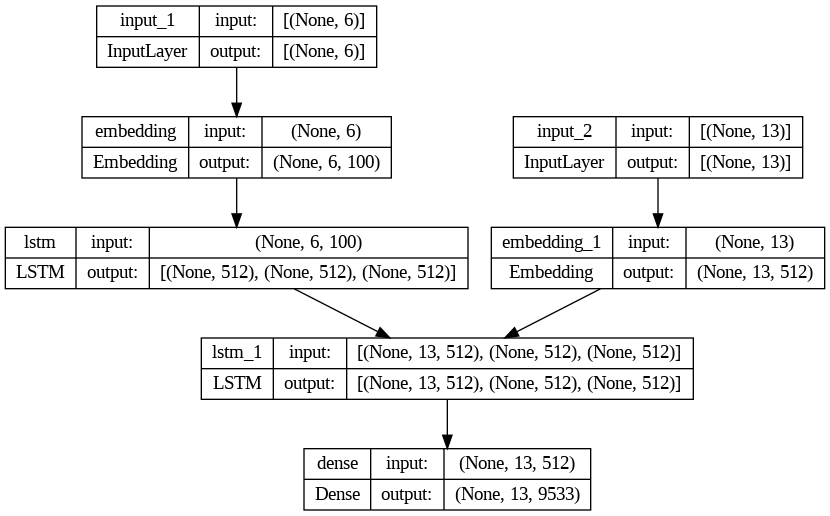

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
r = model.fit(
    [encoder_input_eng_sequences, decoder_input_french_sequences],
    decoder_one_hot_targets,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_split=0.1,
)

Epoch 1/20
282/282 [==============================] - 20s 56ms/step - loss: 2.2435 - accuracy: 0.7014 - val_loss: 2.2721 - val_accuracy: 0.6887
Epoch 2/20
282/282 [==============================] - 10s 34ms/step - loss: 1.8414 - accuracy: 0.7375 - val_loss: 2.1632 - val_accuracy: 0.7011
Epoch 3/20
282/282 [==============================] - 10s 34ms/step - loss: 1.7177 - accuracy: 0.7437 - val_loss: 2.0461 - val_accuracy: 0.6984
Epoch 4/20
282/282 [==============================] - 9s 34ms/step - loss: 1.6073 - accuracy: 0.7524 - val_loss: 1.9458 - val_accuracy: 0.7192
Epoch 5/20
282/282 [==============================] - 10s 34ms/step - loss: 1.5258 - accuracy: 0.7615 - val_loss: 1.9043 - val_accuracy: 0.7225
Epoch 6/20
282/282 [==============================] - 10s 34ms/step - loss: 1.4581 - accuracy: 0.7714 - val_loss: 1.8659 - val_accuracy: 0.7256
Epoch 7/20
282/282 [==============================] - 9s 33ms/step - loss: 1.3963 - accuracy: 0.7798 - val_loss: 1.8288 - val_accuracy: 0

In [ ]:
encoder_prediction_model = Model(encoder_inputs_eng_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)


decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)



decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)


decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)


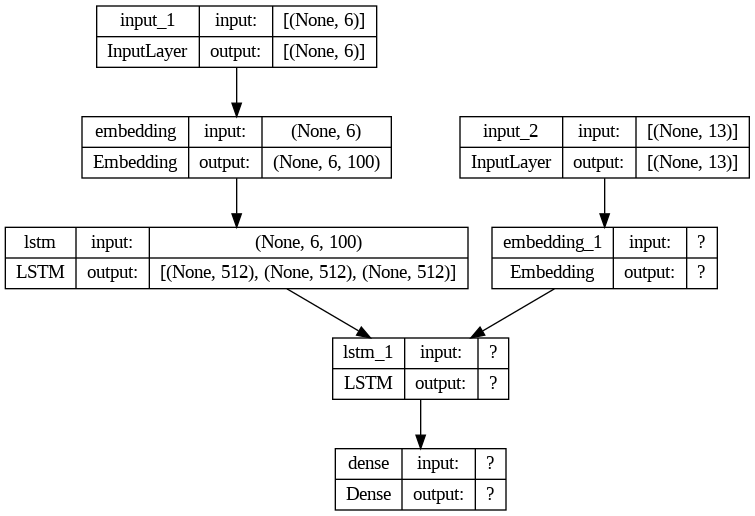

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
idx2word_eng_input = {v:k for k, v in word2idx_eng_inputs.items()}
idx2word_french_target = {v:k for k, v in word2idx_french_outputs.items()}

In [ ]:
def perform_translation(input_seq):
    states_value = encoder_prediction_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_french_outputs['<sos>']
    eos = word2idx_french_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_french_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [ ]:
random_sentence_index = np.random.choice(len(input_english_sentences))
input_eng_seq = encoder_input_eng_sequences[random_sentence_index:random_sentence_index+1]
translation = perform_translation(input_eng_seq)
print('-')
print('engish sentence', input_english_sentences[random_sentence_index])
print('Translated Sentence:', translation)

1/1 [==============================] - 0s 18ms/step
-
engish sentence I was devastated.
Translated Sentence: j'étais été été qui le chance.
